In [1]:
import scipy
import scipy.sparse as sparse
import scipy.sparse.linalg as spalin
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype='complex')
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z,sz, 'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list


def gen_op_total(op_list):
    L = len(op_list)
    tot = op_list[0]
    for i in range(1,L):
        tot = tot + op_list[i]
    return tot

def gen_op_prod(op_list):
    L= len(op_list)
    P = op_list[0]
    for i in range(1, L):
        P = P*op_list[i]
    return P

def gen_interaction_kdist(op_list, op_list2=[],k=1, bc='obc'):
    L= len(op_list)

    if op_list2 ==[]:
        op_list2=op_list
    H = sparse.csr_matrix(op_list[0].shape)
    Lmax = L if bc == 'pbc' else L-k
    for i in range(Lmax):
        H = H+ op_list[i]*op_list2[np.mod(i+k,L)]
    return H

def gen_state_bloch(thetaList, phiList):
    L=len(thetaList)
    psi = np.kron([np.cos(thetaList[0]/2.),np.exp(1j*phiList[0])*np.sin(thetaList[0]/2.)],
                  [np.cos(thetaList[1]/2.),np.exp(1j*phiList[1])*np.sin(thetaList[1]/2.)])
    for i in range(2,L):
        psi = np.kron(psi, [np.cos(thetaList[i]/2.),np.exp(1j*phiList[i])*np.sin(thetaList[i]/2.)])
    return psi

The paper looked at transverse field Ising model with an additional longitudinal field:

$H = -J \sum_i \sigma_i^z \sigma_{i+1}^z + h_x\sum_i \sigma_i^x  + h_z \sum_i \sigma_i^z $

In the inifinite temperature limit, the OTOC for the spin chain is given by: 

$C^{\mu\nu}_{ij}(t) = \frac{1}{2}<[\sigma^{\mu}_i(t),\sigma^{\nu}_j]^2> = 1-Re\{Tr[\sigma^{\mu}_i(t)\sigma^{\nu}_j\sigma^{\mu}_i(t)\sigma^{\nu}_j]\}/D$,

where $D$ is the dimension of the Hilbert space.

In [ ]:
# Mixed Field Ising Model
def MFIM(L, J = 1, hz = 1, hx = 1):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  H = hz * sum(sz_list) + hx * sum(sx_list)
  for i in range(L):
    H += -J * sz_list[i] * sz_list[(i+1)%L]
  return H

def get_first_peak(lst):
    for i in range(1, len(lst) - 1):
        if lst[i] > lst[i - 1] and lst[i] > lst[i + 1]:
            return i 

# Input: mu/nu = "1" (sx), "2" (sy), "3" (sz), i/j ranges from 0 to L-1
def otoc_t(L, J, hz, hx, t, mu, nu, i, k):
  H_mat = MFIM(L, J, hz, hx)
  slist = gen_s0sxsysz(L)
  A = slist[mu][i]
  B = slist[nu][k]
  U = spalin.expm(-1j * H_mat * t) # Compute U(t) = exp(-i * H * t)
  U_dag = U.getH()  # Compute U^{\dagger}
  S_i_t = U_dag @ A @ U  # Compute the time-evolved operator S_i(t)
  product = S_i_t @ B @ S_i_t @ B  # Compute the product S_i(t) S_j S_i(t) S_j
  otoc = 1-np.real(product.diagonal().sum())/(2**L)   # Compute the trace of the product:
  
  return otoc


def get_std(otoc_list, tlist, Dt):
    ts = get_first_peak(otoc_list)
    time_window = otoc_list[ts+1:ts+int(Dt/(tlist[1]-tlist[0]))]
    otoc_norm = otoc_list/np.mean(time_window)
    std = np.sqrt(np.mean((time_window/np.mean(time_window))**2)-1)
    
    return otoc_norm, std



In [10]:
s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(4)

In [14]:
print(sx_list[3].toarray())

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


Computing $C^{\mu\nu}_{ij}(t)$ and normalizing

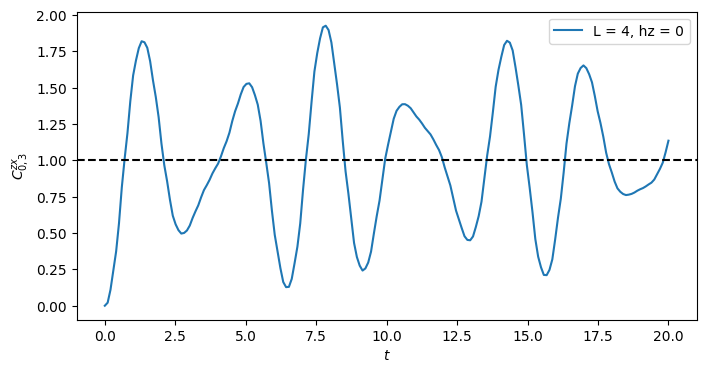

In [28]:
L = 4
Nt = 200
t_end = 20
J= 20
hx = 1
hz = 0
mu = 3
nu = 1
site_1 = 0
site_2 = 3
BC = 'obc'
c_test = np.zeros(Nt) 
tlist = np.linspace(0,t_end,Nt)
for i, t in enumerate(tlist):
    c_test[i] = otoc_t(L,J,hz,hx,t,mu,nu,site_1,site_2)

Dt = 20
otoc_norm, std1 = get_std(c_test, tlist, Dt)

plt.figure(figsize=(8,4))
plt.plot(tlist,otoc_norm, label = f'L = {L}, hz = {hz}')
plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('$t$')
plt.ylabel('$C^{zx}_{0,3} $')
plt.legend()


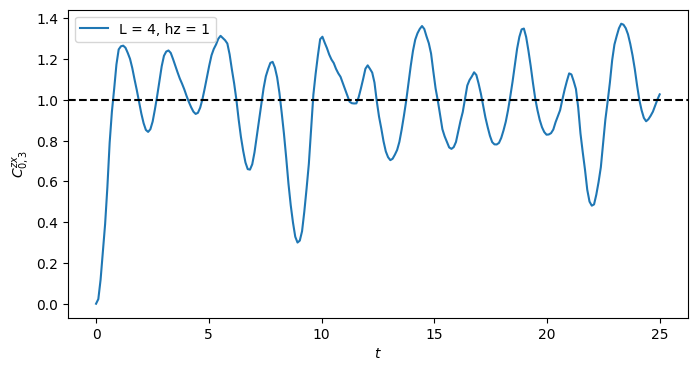

In [31]:
L = 4
Nt = 250
t_end = 25
J= 20
hx = 1
hz = 1
mu = 3
nu = 1
site_1 = 0
site_2 = 3
c_test = np.zeros(Nt) 
tlist = np.linspace(0,t_end,Nt)
for i, t in enumerate(tlist):
    c_test[i] = otoc_t(L,J,hz,hx,t,mu,nu,site_1,site_2)

Dt = 20
otoc_norm, std2 = get_std(c_test, tlist, Dt)

plt.figure(figsize=(8,4))
plt.plot(tlist,otoc_norm, label = f'L = {L}, hz = {hz}')
plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('$t$')
plt.ylabel('$C^{zx}_{0,3} $')
plt.legend()

In [36]:
print(1/std1)
print(1/std2)

3.806673621830983
6.995981605470946


Extracting $\chi$ for various $h_z$: 

$\chi = \frac{\sigma^{-1}-\sigma^{-1}_{min}}{\sigma^{-1}_{max}-\sigma^{-1}_{min}}$. $\chi \rightarrow 0$ is the integrable limit and $\chi \rightarrow 1$ is the chaotic limit.

$\sigma = \sqrt{<c(t)^2>-1}$ of the renormalized OTOC $c(t) = C(t)/<C(t)>$, with the brackets standing for time-average over a time window $\Delta t$.

c:\Users\Huai\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\Huai\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


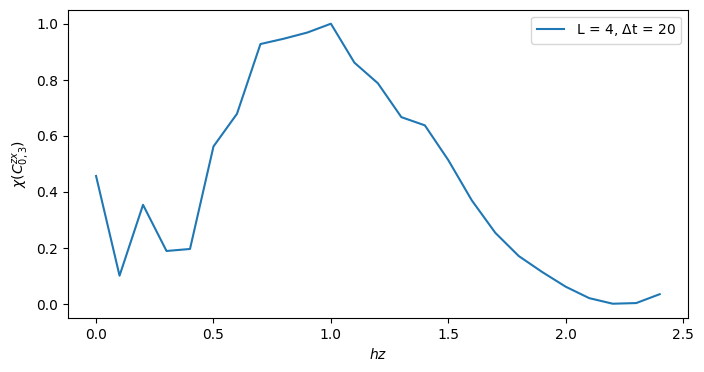

In [ ]:
L = 4
Nt = 250
t_end = 25
J= 4
hx = 1
mu = 3
nu = 1
site_1 = 0
site_2 = 3
Dt = 20

hz_max = 2.5
hz_step = 0.1
hzlist = np.arange(0,hz_max,hz_step)
stdlist = np.zeros(len(hzlist))
for k, hz in enumerate(hzlist):

    c_list = np.zeros(Nt) 
    tlist = np.linspace(0,t_end,Nt)
    for i, t in enumerate(tlist):
        c_list[i] = otoc_t(L,J,hz,hx,t,mu,nu,site_1,site_2)
    _, stdlist[k] = get_std(c_list, tlist, Dt)

std_inv = 1/stdlist
chilist = (std_inv - np.min(std_inv))/(np.max(std_inv)-np.min(std_inv))

plt.figure(figsize=(8,4))
plt.plot(hzlist,chilist, label = rf'L = {L}, $\Delta$t = {Dt}')
plt.xlabel('$hz$')
plt.ylabel('$\chi(C^{zx}_{0,3}) $')
plt.legend()

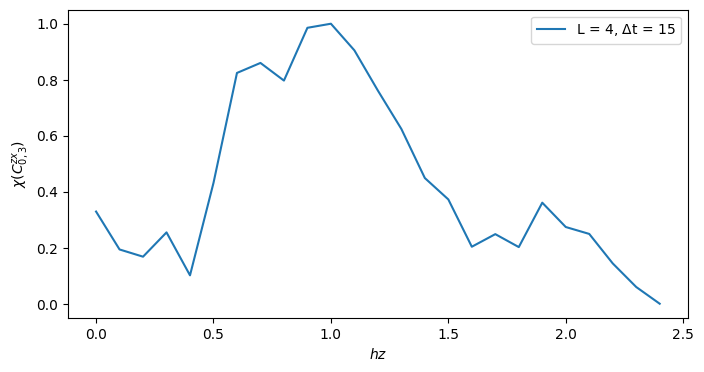

In [37]:
L = 4
Nt = 200
t_end = 20
J= 4
hx = 1
mu = 3
nu = 1
site_1 = 0
site_2 = 3
Dt = 15

hz_max = 2.5
hz_step = 0.1
hzlist = np.arange(0,hz_max,hz_step)
stdlist = np.zeros(len(hzlist))
for k, hz in enumerate(hzlist):

    c_list = np.zeros(Nt) 
    tlist = np.linspace(0,t_end,Nt)
    for i, t in enumerate(tlist):
        c_list[i] = otoc_t(L,J,hz,hx,t,mu,nu,site_1,site_2)
    _, stdlist[k] = get_std(c_list, tlist, Dt)


std_inv = 1/stdlist
chilist = (std_inv - np.min(std_inv))/(np.max(std_inv)-np.min(std_inv))

plt.figure(figsize=(8,4))
plt.plot(hzlist,chilist,  label = rf'L = {L}, $\Delta$t = {Dt}')
plt.xlabel('$hz$')
plt.ylabel('$\chi(C^{zx}_{0,3}) $')
plt.legend()

In [21]:
L = 4
tstep = 0.1
J= 25
hx = 1
mu = 3
nu = 1
site_1 = 0
site_2 = 3
hz_max = 2.5
hz_step = 0.1

dt_min = 10
dt_max = 25

dtlist = np.arange(dt_min, dt_max,5)
hzlist = np.arange(0,hz_max,hz_step)
chilist = np.zeros((len(dtlist),len(hzlist)))
stdlist = np.zeros(len(hzlist))

for l,Dt in enumerate(dtlist):
    t_end = Dt + 5

    for k, hz in enumerate(hzlist):

        c_list = np.zeros(int(t_end/tstep)) 
        tlist = np.arange(0,t_end,tstep)
        for i, t in enumerate(tlist):
            c_list[i] = otoc_t(L,J,hz,hx,t,mu,nu,site_1,site_2)
        _, stdlist[k] = get_std(c_list, tlist, Dt)

    std_inv = 1/stdlist
    chilist[l] = (std_inv - np.min(std_inv))/(np.max(std_inv)-np.min(std_inv))


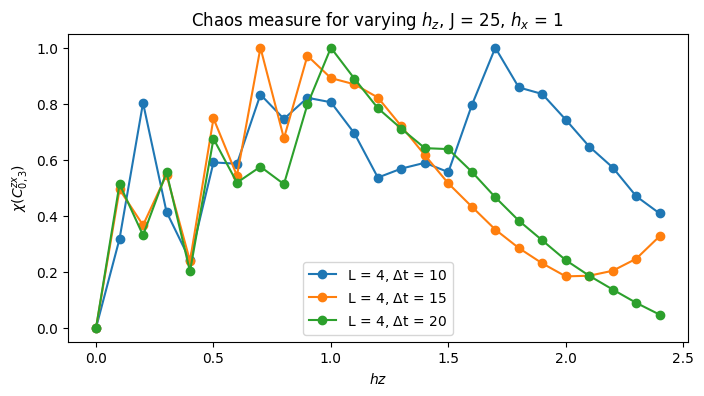

In [22]:
# Integrable limit: 𝜒 -> 0; Chaos limit: 𝜒 -> 1
plt.figure(figsize=(8,4))
for l, Dt in enumerate(dtlist):
    plt.plot(hzlist,chilist[l], "-o", label = rf'L = {L}, $\Delta$t = {Dt}')
plt.xlabel('$hz$')
plt.ylabel('$\chi(C^{zx}_{0,3}) $')
plt.title(rf"Chaos measure for varying $h_z$, J = {J}, $h_x$ = {hx}")
plt.legend()

In [23]:
L = 4
tstep = 0.1
J= 25
hx = 1
mu = 3
nu = 3
site_1 = 0
site_2 = 1
hz_max = 2.5
hz_step = 0.1

dt_min = 10
dt_max = 25

dtlist = np.arange(dt_min, dt_max,5)
hzlist = np.arange(0,hz_max,hz_step)
chilist = np.zeros((len(dtlist),len(hzlist)))
stdlist = np.zeros(len(hzlist))

for l,Dt in enumerate(dtlist):
    t_end = Dt + 5

    for k, hz in enumerate(hzlist):

        c_list = np.zeros(int(t_end/tstep)) 
        tlist = np.arange(0,t_end,tstep)
        for i, t in enumerate(tlist):
            c_list[i] = otoc_t(L,J,hz,hx,t,mu,nu,site_1,site_2)
        _, stdlist[k] = get_std(c_list, tlist, Dt)

    std_inv = 1/stdlist
    chilist[l] = (std_inv - np.min(std_inv))/(np.max(std_inv)-np.min(std_inv))

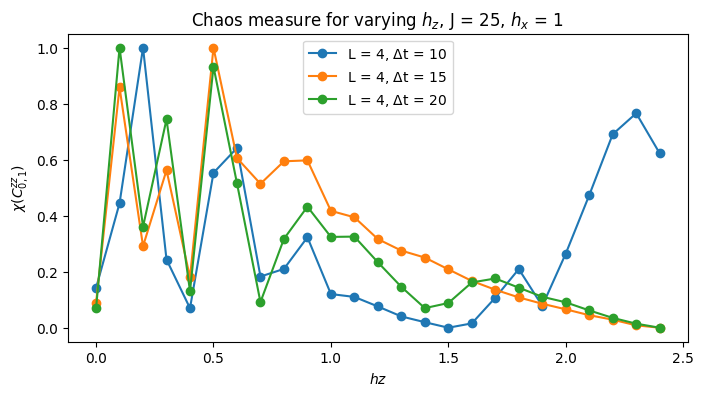

In [24]:
# Integrable limit: 𝜒 -> 0; Chaos limit: 𝜒 -> 1
plt.figure(figsize=(8,4))
for l, Dt in enumerate(dtlist):
    plt.plot(hzlist,chilist[l], "-o", label = rf'L = {L}, $\Delta$t = {Dt}')
plt.xlabel('$hz$')
plt.ylabel('$\chi(C^{zz}_{0,1})$')
plt.title(rf"Chaos measure for varying $h_z$, J = {J}, $h_x$ = {hx}")
plt.legend()